In [104]:
using CSV, DataFrames
using FileIO, Dates
using PyCall
using DelimitedFiles
using CairoMakie

include("./src/cubes.jl")
include("./src/motifs_analysis.jl")

@pyimport powerlaw as powlaw
so = pyimport("scipy.optimize")

PyObject <module 'scipy.optimize' from 'C:\\Users\\gabipana\\.julia\\conda\\3\\lib\\site-packages\\scipy\\optimize\\__init__.py'>

In [105]:
region = "japan"
motif = "Triangle"
if region == "romania"
    cell_sizes = [3.0, 3.5];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 10.0]
    multipliers = [1.0, 10.0]
elseif region == "california"
    cell_sizes = [1.0, 2.0];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 1.0]
    multipliers = [1.0, 1.0]
elseif region == "italy"
    cell_sizes = [4.0, 4.5];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 10.0]
    multipliers = [1.0, 10.0]
elseif region == "japan"
    cell_sizes = [2.5, 3.0];
    minimum_magnitudes = [3, 2];
    all_data_multipliers = [1.0, 10.0]
    multipliers = [1.0, 10.0]
end

2-element Vector{Float64}:
  1.0
 10.0

In [106]:
weighted_by = "totalenergy"
# cell_size = cell_sizes[2]
minimum_magnitude = minimum_magnitudes[1]

# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);

if weighted_by == "totalenergy"
    weight_key = 1
else 
    weight_key = 2
end

# Make path for plot results
mkpath("./motifs_selected_plots/tsallis/$weighted_by/$region")

# Read results of fit to get xmin 
results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);

In [107]:
i=2

2

In [108]:
cell_size = cell_sizes[i]
if region == "japan"
    minimum_magnitude = minimum_magnitudes[i]
elseif (region == "romania") | (region == "italy") |  (region == "california")
    minimum_magnitude = minimum_magnitudes[1]
end

#############################################################################################################################################################
# Filter by magnitude
df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);

# Get the motif
network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
motifs = readdlm(network_target_path * motif_filename, ',', Int64);

# Energy and areas calculator
motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
areas = area_triangles(motifs, df_filtered_cubes);

# Area weighted by total/mean energy
area_weight = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if areas[key] > 1
        push!(area_weight, areas[key]/motif_energy[key][weight_key])
    end
end
#############################################################################################################################################################
# THE FIT
# Select xmin based on weighted_by, region, motif, cell_size and minmag

# xmin_results = results[(results.weighted_by .== weighted_by) .& 
# (results.region .== region) .& 
# (results.motif .== motif) .& 
# (results.cell_size .== cell_size) .&
# (results.minmag .== minimum_magnitude),:].xmin;

# # Powerlaw fit
# fit = powlaw.Fit(area_weight, xmin=xmin_results);
# alpha = fit.alpha
# xmin = fit.xmin
# KS = fit.power_law.KS(data=area_weight)

x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(area_weight)

([1.7639206087230665e-9, 1.7680780529594164e-9, 1.7734336477152207e-9, 1.773627155070807e-9, 1.7746185018017718e-9, 1.7773375208337614e-9, 1.7798465414443832e-9, 1.7805417236295843e-9, 1.7831997470486298e-9, 1.8168262516899596e-9  …  209.89127308848543, 243.35336929189728, 256.81668000534853, 279.05672872579646, 326.72642659644396, 330.3078450963301, 497.1342022755521, 497.3385653771332, 501.99013112072987, 983.3069212470922], [1.0, 0.9999825391559428, 0.9999650783118856, 0.9999476174678283, 0.9999301566237712, 0.999912695779714, 0.9998952349356568, 0.9998777740915996, 0.9998603132475424, 0.9998428524034851  …  0.00017460844057204383, 0.00015714759651486165, 0.00013968675245756845, 0.00012222590840038627, 0.0001047650643432041, 8.730422028602192e-5, 6.984337622883974e-5, 5.238253217165756e-5, 3.492168811436436e-5, 1.746084405718218e-5])

In [109]:
fit_tsallis = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
# @. tsallis_ccdf(x, α, λ, c) = c*((1+x/λ)^(-α))
# @. tsallis_ccdf(x, α, λ, c) = real(c*(Complex(1+x/(λ))^(-α)))
@. tsallis_ccdf(x, α, λ, c) = c*((1+x/(λ))^(-α))
# popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, p0=[2, 7, 0.8], bounds=(0, Inf), maxfev=5000)
popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, bounds=(0, Inf), maxfev=3000)


alpha = round(popt_tsallis[1], digits=4)
lambda = round(popt_tsallis[2], digits=4)
c = round(popt_tsallis[3], digits=4)
println("alpha= ", popt_tsallis[1],"\nlambda= ", popt_tsallis[2], "\nc= ", popt_tsallis[3])

alpha= 0.21739246865085612
lambda= 1.1990981875589125e-6
c= 0.9801450832632587


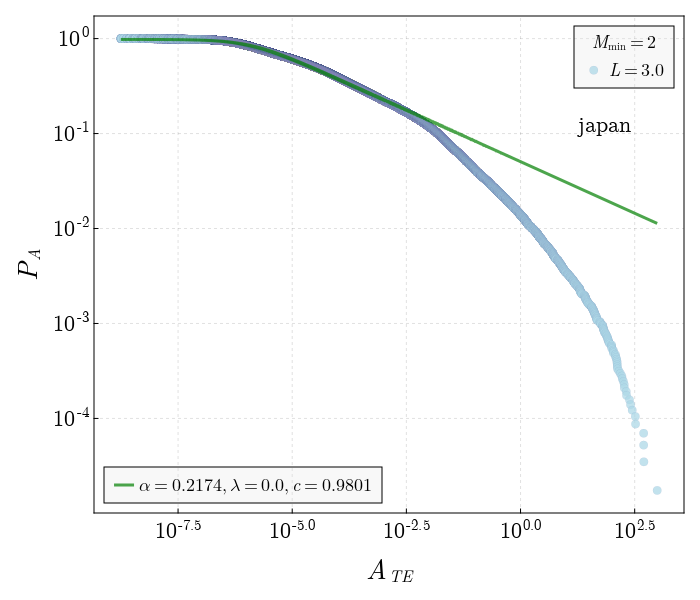

In [110]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :circle]
colors=[:lightblue, :lightgreen]
line_colors=[:midnightblue, :green]

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)


#############################################################################################################################################################
#############################################################################################################################################################
# THE PLOTS 
# CCDF of truncated data (fitted), x and y values


sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(colors[1], 0.75), strokewidth=0.05, strokecolor=(line_colors[1], 0.8), marker=markers[i], markersize=12)


lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, popt_tsallis[1], popt_tsallis[2], popt_tsallis[3]), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
    color=(line_colors[2], 0.7), linewidth=3)


text!(ax1, region, space = :relative, position = Point2f(0.82, 0.75), fontsize=22)

# AXIS LEGEND
axislegend(ax1, [sc1], 
[L"L=%$(cell_sizes[i])"], L"M_\mathrm{min}=%$(minimum_magnitude)",
position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

save("./motifs_selected_plots/tsallis/$weighted_by/$region/motif$(motif)_$(region)_area_$(weighted_by)_cell_size_$(cell_size).png", fig, px_per_unit=7)
fig